# <a id='toc1_'></a>[Trading Strategy](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Trading Strategy](#toc1_)    
- [Import libraries](#toc2_)    
- [Import data](#toc3_)    
- [10-1 portfolio](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Import libraries](#toc0_)

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

from pathlib import Path
import sys
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))
from libs.functions import *

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

# <a id='toc3_'></a>[Import data](#toc0_)

In [2]:
preds = pd.read_csv('data/predictions.csv')
preds.rename(columns={'Unnamed: 0': 'index_original'}, inplace=True)
preds.columns = preds.columns.str.lower()
preds['timestamp'] = pd.to_datetime(preds['timestamp']) + pd.offsets.MonthEnd(1) # add one month as the target is the prediction for the next month
preds['y_true_full'] = preds['y_true'] + ((1+preds['discount'])**(1/12)-1) # add back the short rate to get the true return
data_raw = pd.read_csv('data/data.csv')
omxc25_tickers = pd.read_csv('data/omxc25_constit.csv')
omxc25_tickers = omxc25_tickers[['timestamp', 'ticker']]
omxc25_tickers['in_c25'] = True
omxc25_tickers['timestamp'] = pd.to_datetime(omxc25_tickers['timestamp'])
omxc25_price = pd.read_csv('data/omxc25_price.csv')
omxc25_price['timestamp'] = pd.to_datetime(omxc25_price['timestamp'])
omxc25_price = omxc25_price[(omxc25_price['timestamp'] >= '2021-01-01') & (omxc25_price['timestamp'] <= '2024-12-31')]
omxcb_tickers = pd.read_csv('data/omxcb_constit.csv')
omxcb_tickers = omxcb_tickers[['timestamp', 'ticker']]
omxcb_tickers['timestamp'] = pd.to_datetime(omxcb_tickers['timestamp'])
omxcb_tickers['in_cb'] = True 
omxcb_price = pd.read_csv('data/omxcb_price.csv')
omxcb_price['timestamp'] = pd.to_datetime(omxcb_price['timestamp'])
omxcb_price = omxcb_price[(omxcb_price['timestamp'] >= '2021-01-01') & (omxcb_price['timestamp'] <= '2024-12-31')]

In [3]:
df = (preds
      .merge(omxc25_tickers, on=['ticker','timestamp'], how='left')
      .merge(omxcb_tickers, on=['ticker','timestamp'], how='left')
)
df['in_c25'] = np.where(df['in_c25'].isna(), False, df['in_c25'])
df['in_cb'] = np.where(df['in_cb'].isna(), False, df['in_cb'])

# df = df[df['in_cb'] == True]
df = df[df['in_c25'] == True]

# <a id='toc4_'></a>[10-1 portfolio](#toc0_)

In [4]:
# # make excess returns
# # plot long and short separately (similar to gu)
# # Make tables similar to gu pp 2266-2267

# # create deciles
# df['decile_ols'] = df.groupby(['timestamp'])['ols'].transform(deciles)
# df['decile_lasso'] = df.groupby(['timestamp'])['lasso'].transform(deciles)
# df['decile_mlp'] = df.groupby(['timestamp'])['mlp'].transform(deciles)
# df['decile_mlp-pyr'] = df.groupby(['timestamp'])['mlp-pyr'].transform(deciles)


In [5]:
# # calculate portfolio returns
# df.sort_values(by=['timestamp'])
# port_10_1 = pd.DataFrame()
# models = {
#     'ols':      'decile_ols',
#     'lasso':    'decile_lasso',
#     'mlp':      'decile_mlp',
#     'mlp-pyr':  'decile_mlp-pyr'
# }

# tmp_dfs = {}

# for model, decile in models.items():
#     tmp = df.copy(deep=True)
#     tmp = tmp[['timestamp', 'ticker', decile, 'y_true_full']]
    
#     tmp['action'] = np.where(tmp[decile] == 0, -1, np.where(tmp[decile] == 9, 1, 0))


#     tmp['n_short'] = (tmp['action'] == -1).astype(int)
#     tmp['n_long'] = (tmp['action'] == 1).astype(int)


#     tmp['n_short'] = tmp.groupby('timestamp')['n_short'].transform('sum')
#     tmp['n_long'] = tmp.groupby('timestamp')['n_long'].transform('sum')

#     tmp[f'{model}_return'] = np.where(tmp['action'] == 1, tmp['y_true_full']/tmp['n_long'],
#                             np.where(tmp['action'] == -1, - tmp['y_true_full']/tmp['n_short'], 0))

#     tmp_df = tmp.copy(deep=True)
#     # drop rows with action == 0
#     tmp_df = tmp_df[tmp_df['action'] != 0]
#     tmp_dfs[model] = tmp_df
    
#     tmp = tmp.groupby('timestamp')[f'{model}_return'].sum().reset_index()
#     tmp[f'{model}_return'] = tmp[f'{model}_return'] + 1
#     tmp[f'{model}_return_cum'] = tmp[f'{model}_return'].cumprod() * 100
#     tmp[f'{model}_return'] = tmp[f'{model}_return'] - 1

#     port_10_1 = pd.concat([port_10_1, tmp], axis=1)
# port_10_1 = port_10_1.loc[:, ~port_10_1.columns.duplicated()]
# port_10_1.loc[-1] = [pd.Timestamp('2021-01-01'), 0, 100, 0, 100, 0, 100, 0, 100]
# port_10_1 = port_10_1.sort_index().reset_index(drop=True)


In [6]:
# calculate portfolio returns
df.sort_values(by=['timestamp'])
port_10_1 = pd.DataFrame()
models = ['ols','lasso','mlp','mlp-pyr']

for model in models:
    for dir in ['long', 'short']:
        tmp = df.copy(deep=True)
        tmp = tmp[['timestamp', model, 'y_true_full']]
        tmp['decile'] = df.groupby(['timestamp'])[model].transform(deciles)
        # create action column based on decile
        if dir == 'long':
            tmp['action'] = np.where(tmp['decile'] == 9, 1, 0)
        else:
            tmp['action'] = np.where(tmp['decile'] == 0, -1, 0)
        # find stocks in position
        tmp[f'n_dir'] = (tmp['action'] == (1 if dir == 'long' else -1)).astype(int)
        tmp[f'n_dir'] = tmp.groupby('timestamp')[f'n_dir'].transform('sum')
        
        # calculate return for the direction (equal weighted)  
        tmp[f'{model}_{dir}'] = tmp['action']*tmp['y_true_full']/tmp[f'n_dir'] # multiply by action to get the return for the direction

        # sum the returns for each month
        tmp = tmp.groupby('timestamp')[f'{model}_{dir}'].sum().reset_index()
        # calculate cumulative return and percentage return
        tmp[f'{model}_{dir}'] = tmp[f'{model}_{dir}'] + 1
        tmp[f'{model}_{dir}_cum'] = tmp[f'{model}_{dir}'].cumprod() * 100
        tmp[f'{model}_{dir}'] = tmp[f'{model}_{dir}'] - 1

        port_10_1 = pd.concat([port_10_1, tmp], axis=1)
port_10_1 = port_10_1.loc[:, ~port_10_1.columns.duplicated()]
# start with an initial value of 100
port_10_1.loc[-1] = [pd.Timestamp('2021-01-01'), np.nan, 100, np.nan, 100, np.nan, 100, np.nan, 100, np.nan, 100, np.nan, 100, np.nan, 100, np.nan, 100]
port_10_1 = port_10_1.sort_index().reset_index(drop=True)


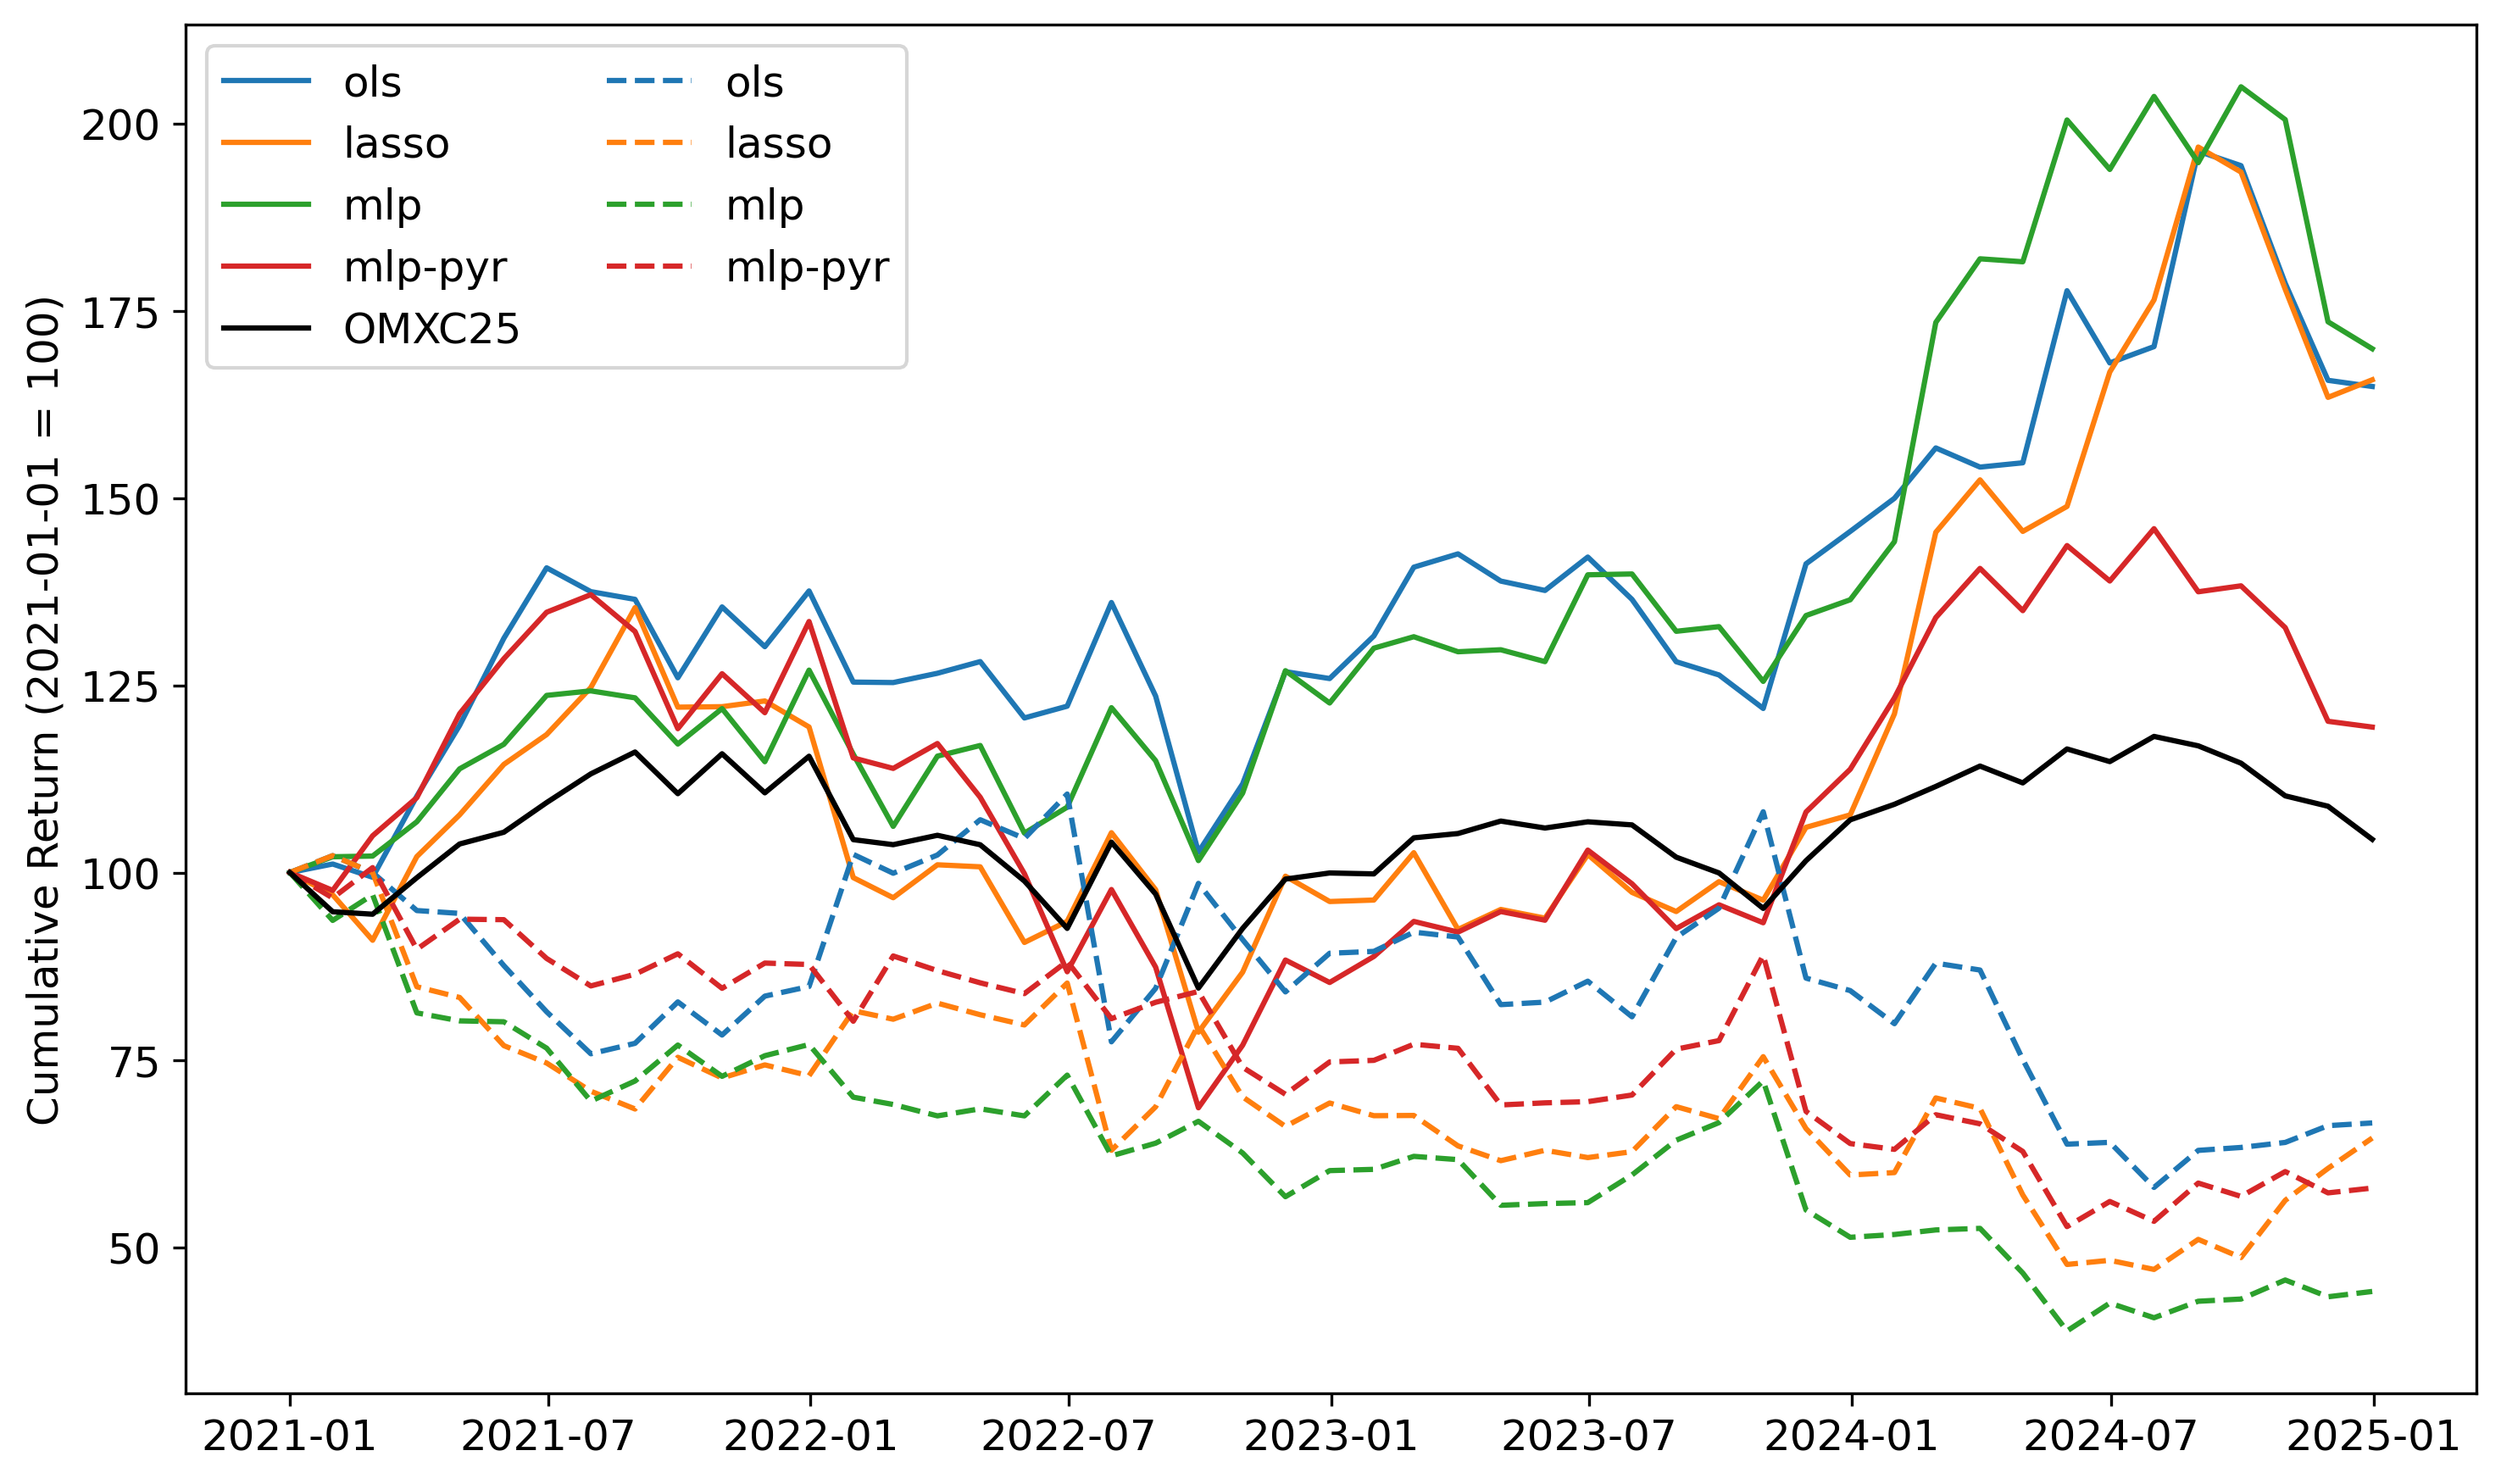

In [7]:
# plotting
plt.figure(figsize=(10, 6))
default_cycler = plt.rcParams['axes.prop_cycle']
for dir in ['long', 'short']:
    # reset color maping to start with the same colors for each direction
    ax = plt.gca()
    ax.set_prop_cycle(default_cycler)
    for model in models:    
        plt.plot(port_10_1['timestamp'], port_10_1[f'{model}_{dir}_cum'], label=f'{model}', linestyle='-' if dir == 'long' else '--')
plt.plot(omxc25_price['timestamp'], omxc25_price['rebased'], label='OMXC25', linestyle='-', color='black')
plt.ylabel('Cumulative Return (2021-01-01 = 100)')
# reordering the labels
handles, labels = plt.gca().get_legend_handles_labels()

# specify order
order = [0, 1, 2, 3, 8, 4, 5, 6, 7]

# pass handle & labels lists along with order as below
plt.legend([handles[i] for i in order], [labels[i] for i in order],ncol=2, loc='upper left', frameon=True)
# plt.legend()
plt.tight_layout()
plt.show()
plt.close()

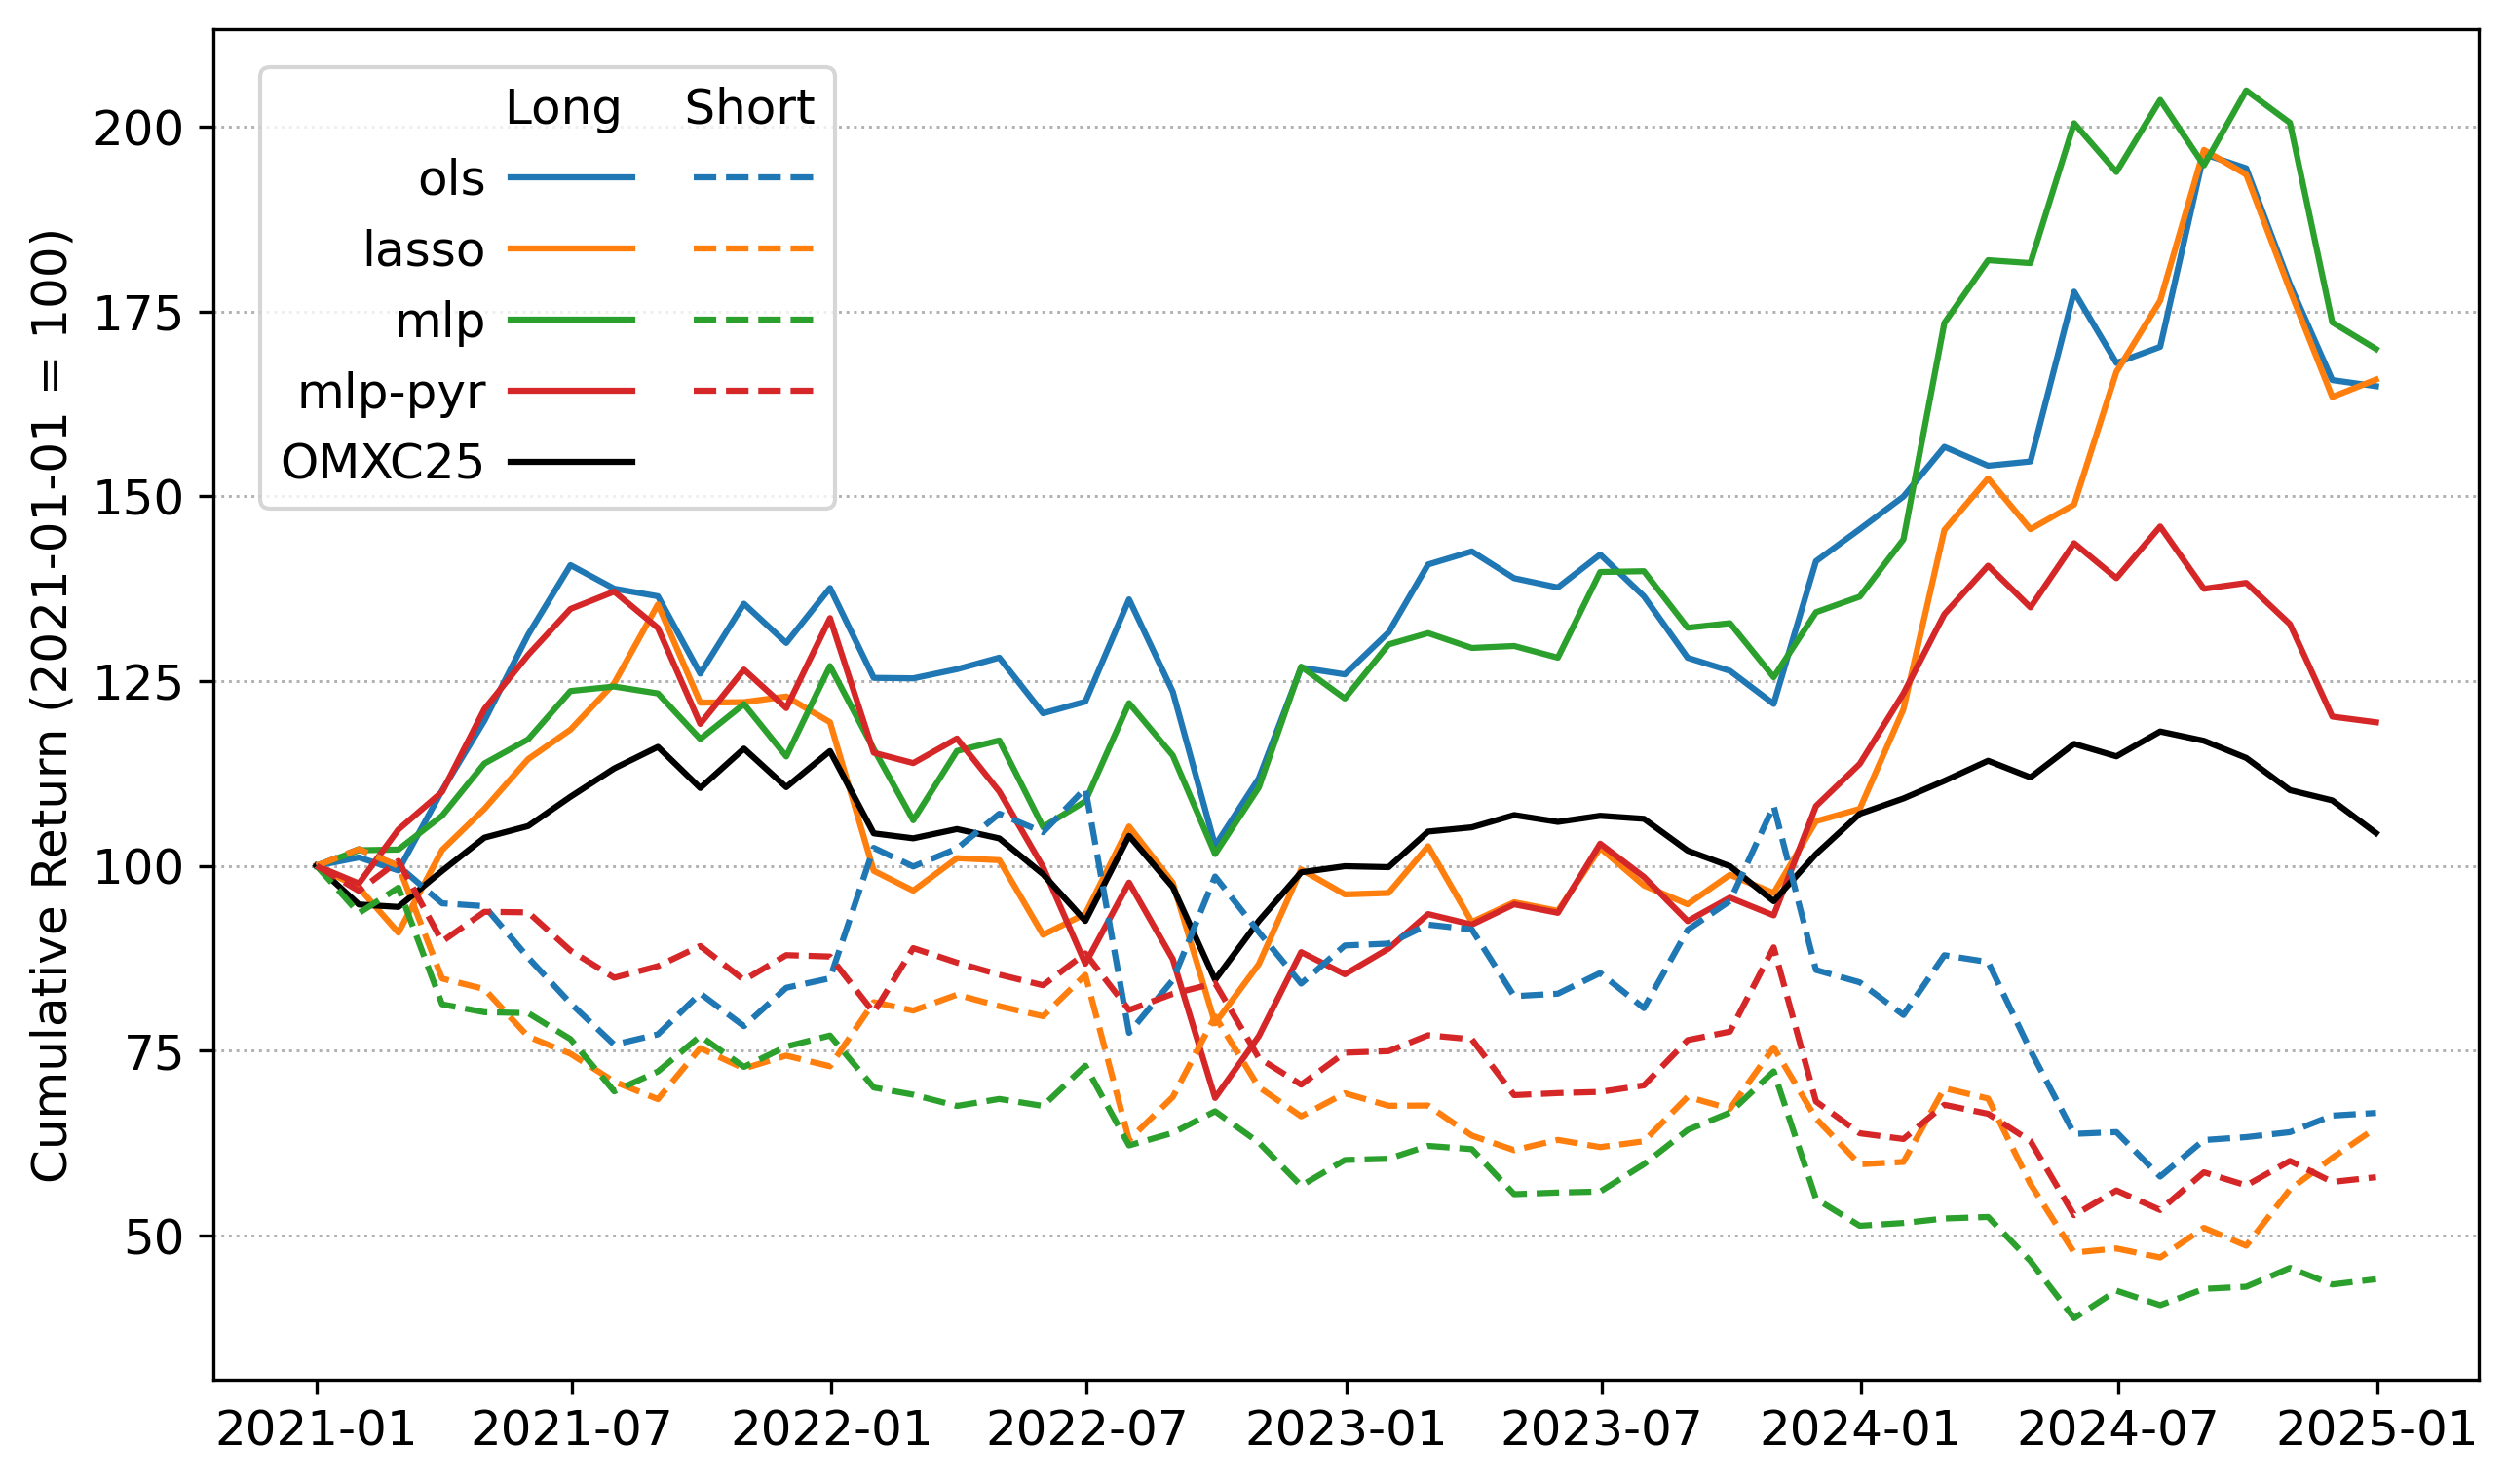

In [103]:
# plotting
fig, ax = plt.subplots(figsize=(10, 6))
default_cycler = plt.rcParams['axes.prop_cycle']
for model in models:    
    ax.plot(port_10_1['timestamp'], port_10_1[f'{model}_long_cum'], label=f'{model}', linestyle='-')
ax.plot(omxc25_price['timestamp'], omxc25_price['rebased'], label='OMXC25', linestyle='-', color='black')
ax = plt.gca()
ax.set_prop_cycle(default_cycler)
for model in models:    
    ax.plot(port_10_1['timestamp'], port_10_1[f'{model}_short_cum'], label=f' ', linestyle='--')
ax.set_ylabel('Cumulative Return (2021-01-01 = 100)')
ax.yaxis.grid(True, which='major', linestyle=':', linewidth=0.7)

leg = ax.legend(ncol=2, loc='upper left',frameon=True, markerfirst=False, handlelength=2.5,handletextpad=0.5, bbox_to_anchor=(0.01, 0.99, 0.275 ,0.0), mode='expand', title='Long    Short')
leg._legend_box.align = "right"

plt.savefig('figs/port10-1_return.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Sign-only

In [11]:
# port_directional = pd.DataFrame()

# for model in models.keys():
#     tmp = df.copy(deep=True)
#     tmp['action'] = np.where(np.sign(tmp[model]) == 1, 1, np.where(np.sign(tmp[model]) == -1, -1, 0))
#     tmp['action'] = np.where(np.sign(tmp[model]) == 1, 1, -1)

#     tmp['n_short'] = (tmp['action'] == -1).astype(int)
#     tmp['n_long'] = (tmp['action'] == 1).astype(int)

#     tmp['n_short'] = tmp.groupby('timestamp')['n_short'].transform('sum')
#     tmp['n_long'] = tmp.groupby('timestamp')['n_long'].transform('sum')


#     tmp[f'{model}_return'] = np.where(tmp['action'] == 1, tmp['y_true_full']/tmp['n_long'],
#                         np.where(tmp['action'] == -1, - tmp['y_true_full']/tmp['n_short'], 0))
#     # pure one directional strategy
#     # tmp[f'{model}_return'] = np.where(tmp['action'] == 1, tmp['y_true_full']/tmp['n_long'],0)
#     # tmp[f'{model}_return'] = np.where(tmp['action'] == -1, - tmp['y_true_full']/tmp['n_short'],0)

#     tmp = tmp.groupby('timestamp')[f'{model}_return'].sum().reset_index()
#     tmp[f'{model}_return'] = tmp[f'{model}_return'] + 1
#     tmp[f'{model}_return_cum'] = tmp[f'{model}_return'].cumprod() * 100
#     tmp[f'{model}_return'] = tmp[f'{model}_return'] - 1
    
#     port_directional = pd.concat([port_directional, tmp], axis=1)
# port_directional = port_directional.loc[:, ~port_directional.columns.duplicated()]
# port_directional.loc[-1] = [pd.Timestamp('2021-01-01'), 0, 100, 0, 100, 0, 100, 0, 100]
# port_directional = port_directional.sort_index().reset_index(drop=True)

In [12]:
# # plotting
# plt.figure(figsize=(10, 6))
# for model in models.keys():
#     plt.plot(port_directional['timestamp'], port_directional[f'{model}_return_cum'], label=model)
# plt.plot(omxc25_price['timestamp'], omxc25_price['rebased'], label='OMXC25', linestyle='--')
# # plt.plot(omxcb_price['timestamp'], omxcb_price['rebased'], label='OMXCB', linestyle='--')
# # plt.title('Cumulative Returns by Model')
# # plt.xlabel('Timestamp')
# plt.ylabel('Cumulative Return (2021-01-01 = 100)')
# plt.legend()
# plt.tight_layout()
# plt.show()
# plt.close()